In [23]:
import json
import matplotlib
from matplotlib import pyplot as plt
import pickle
import sklearn
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

# Binned Data

In [30]:
filtered_everything = pd.read_csv('../../data/raw-data/filtered_everything.csv', index_col=0)


In [35]:
print(f'COF: ({filtered_everything["COF"].min()} - {filtered_everything["COF"].max()})')
print(f'intercept: ({filtered_everything["intercept"].min()} - {filtered_everything["intercept"].max()})')

COF: (0.0737549238333333 - 0.1966532063)
intercept: (0.0074703459 - 7.94156210692)


In [2]:
oresults_path = '../predicted-results/original/nbins-10'
mresults_path = '../predicted-results/mixed5050/nbins-10'
eresults_path = '../predicted-results/everything/nbins-10'

omodels_path = '../models/original'
mmodels_path = '../models/mixed5050/nbins-10'
emodels_path = '../models/everything/nbins-10'

test_sets = ['5050', '2575', 'everything']

mpoints = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 'all']
epoints = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 4000, 6000, 'all']



In [3]:
with open(f'{emodels_path}/set_1/COF_all.pickle', 'rb') as cof:
    mmodel_cof = pickle.load(cof)

with open(f'{emodels_path}/set_1/intercept_all.pickle', 'rb') as f0:
    mmodel_f0 = pickle.load(f0)

In [4]:
print(len(mmodel_cof.oob_prediction_))
print(len(mmodel_f0.oob_prediction_))

7816
7816


In [5]:
results = {'5050': {'COF': dict(),
                    'intercept': dict()},
           '2575': {'COF': dict(),
                    'intercept': dict()},
           'everything': {'COF': dict(),
                          'intercept': dict()}}
# First deal with the original models 
for tset in results:
    for target in ['COF', 'intercept']:
        with open(f'{omodels_path}/{target}.pickle', 'rb') as f:
            model = pickle.load(f)
        with open(f'{omodels_path}/{target}.ptxt', 'rb') as f:
            features = pickle.load(f)
        with open(f'{oresults_path}/{target}_on_{tset}.json', 'r') as f:
            data = json.load(f)
        results[tset][target]['original'] = {
#             'model': model,
#             'features': features,
#             'data': data,
              'n_train': len(model.oob_prediction_),
              'r_square': data[target]['r_square']
        }

# Then deal with the 5050 mixed models 
for tset in results:
    for i in range(5):
        for point in mpoints:
            for target in ['COF', 'intercept']:
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{mresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    results[tset][target][f'5050_{point}'] = {
    #                 'model': model,
    #                 'features': features,
    #                 'data': data,
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    results[tset][target][f'5050_{point}']['r_square'].append(data[target]['r_square'])
# Lastly deal with the everything models
for tset in results:
    for i in range(5):
        for point in epoints:
            for target in ['COF', 'intercept']:
                with open(f'{emodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{emodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{eresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    results[tset][target][f'everything_{point}'] = {
    #                 'model': model,
    #                 'features': features,
    #                 'data': data,
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    results[tset][target][f'everything_{point}']['r_square'].append(data[target]['r_square'])


In [6]:
for tset in results:
    for target in ['COF', 'intercept']:
        for point in mpoints:
            # doi: dict of interest
            doi = results[tset][target][f'5050_{point}']
            doi['r_square_avg'] = np.average(doi['r_square'])
            doi['r_square_std'] = np.std(doi['r_square'])

        for point in epoints:
            doi = results[tset][target][f'everything_{point}']
            doi['r_square_avg'] = np.average(doi['r_square'])
            doi['r_square_std'] = np.std(doi['r_square'])
            

## Combination R<sup>2</sup> Plots

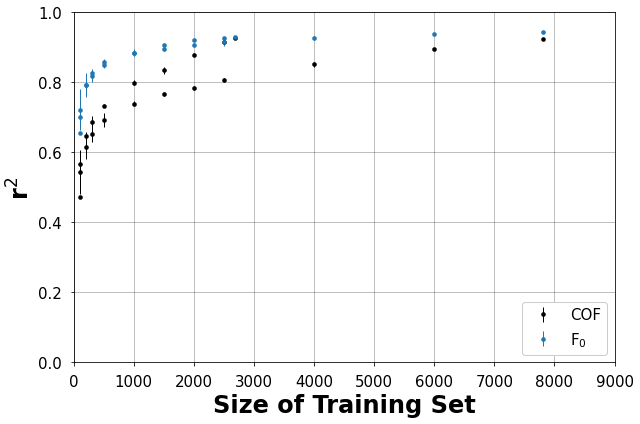

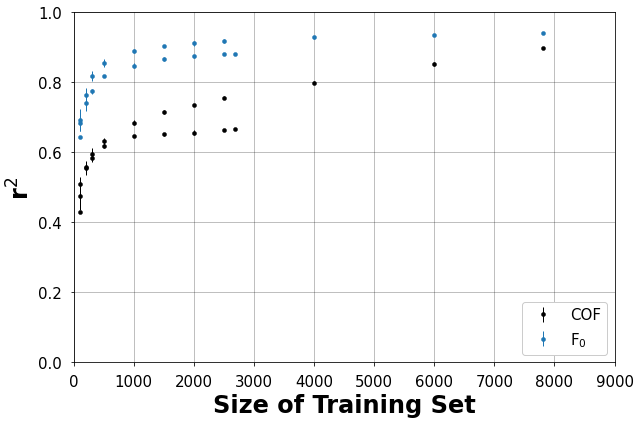

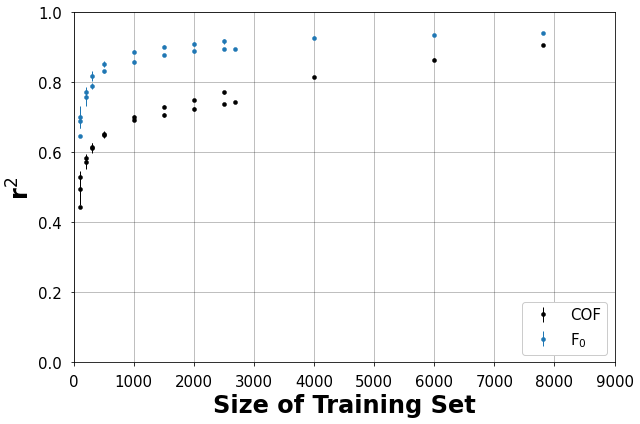

In [7]:
for tset in test_sets:
    to_plot = {'COF': {'n_train': list(),
                       'r_square_avg': list(),
                       'r_square_std': list()},
               'intercept': {'n_train': list(),
                             'r_square_avg': list(),
                             'r_square_std': list()}}
    for target in ['COF', 'intercept']:
        for model, data in results[tset][target].items():
            #print(data)
            try:
                to_plot[target]['r_square_avg'].append(data['r_square_avg'])
                to_plot[target]['r_square_std'].append(data['r_square_std'])
                to_plot[target]['n_train'].append(data['n_train'])

            except KeyError:
                to_plot[target]['n_train'].append(data['n_train'])
                to_plot[target]['r_square_avg'].append(data['r_square'])
                to_plot[target]['r_square_std'].append(0)
                
    #print(to_plot)
    #plt.title('Effect of Training Set Size', fontsize=20, fontweight='bold')
    plt.figure(figsize=[9, 6])
    plt.xlabel('Size of Training Set')
    plt.ylabel('r$^2$', fontweight='bold')
    plt.xlim(0, 9000)
    plt.ylim(0, 1)
    plt.errorbar(x=to_plot['COF']['n_train'],
                 y=to_plot['COF']['r_square_avg'],
                 yerr=to_plot['COF']['r_square_std'],
                 color='black',
                 fmt='.',
                 elinewidth=1)
    plt.errorbar(x=to_plot['intercept']['n_train'],
                 y=to_plot['intercept']['r_square_avg'],
                 yerr=to_plot['intercept']['r_square_std'],
                 fmt='.',
                 elinewidth=1)
    plt.legend(['COF', 'F$_0$'], loc=4)

## Refined R<sup>2</sup> plot
### Mixed 5050 models on 5050 test set

In [8]:
from numpy import *
from matplotlib.pyplot import *

In [9]:
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.bf'] = 'DejaVu Sans:italic:bold'


In [10]:
markersize=6
COF_color = 'dodgerblue'
F0_color = 'firebrick'

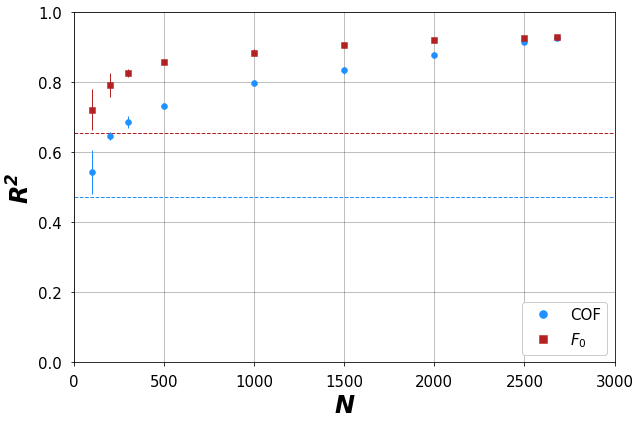

In [24]:
to_plot_on_5050 = {'COF': {'n_train': list(),
                           'r_square_avg': list(),
                           'r_square_std': list(),
                           'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['5050'][target].items():
        if '5050' in model:
            to_plot_on_5050[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_5050[target]['r_square_std'].append(data['r_square_std'])
            to_plot_on_5050[target]['n_train'].append(data['n_train'])
        elif 'original' in model: 
            to_plot_on_5050[target]['base'] = data['r_square']
                
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0, 3000)
plt.ylim(0, 1)
# plt.errorbar(x=to_plot_on_5050['COF']['n_train'],
#             y=to_plot_on_5050['COF']['r_square_avg'],
#             yerr=to_plot_on_5050['COF']['r_square_std'],
#             color='black',
#             fmt='.',
#             elinewidth=1)
plt.errorbar(x=to_plot_on_5050['COF']['n_train'],
            y=to_plot_on_5050['COF']['r_square_avg'],
            yerr=to_plot_on_5050['COF']['r_square_std'],
            color=COF_color,
            fmt='o',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_5050['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

# plt.errorbar(x=to_plot_on_5050['intercept']['n_train'],
#             y=to_plot_on_5050['intercept']['r_square_avg'],
#             yerr=to_plot_on_5050['intercept']['r_square_std'],
#             fmt='.',
#             elinewidth=1)
plt.errorbar(x=to_plot_on_5050['intercept']['n_train'],
            y=to_plot_on_5050['intercept']['r_square_avg'],
            yerr=to_plot_on_5050['intercept']['r_square_std'],
            color=F0_color,
            fmt='s',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_5050['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)

# legend_elements = [Line2D([0], [0], marker='o', color='black', linestyle='', label='COF'),
#                    Line2D([0], [0], marker='o', color='steelblue', linestyle='', label='F$_0$')]
legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/5050_on_5050.pdf', dpi=500)

# print('COF')
# print(f'n: {to_plot_on_5050["COF"]["n_train"]}')
# print(f'r2: {to_plot_on_5050["COF"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_5050["COF"]["r_square_std"]}')

# print('F0')
# print(f'n: {to_plot_on_5050["intercept"]["n_train"]}')
# print(f'r2: {to_plot_on_5050["intercept"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_5050["intercept"]["r_square_std"]}')
     

# Refined R<sup>2</sup> plot 
### Everything models on 5050 test set

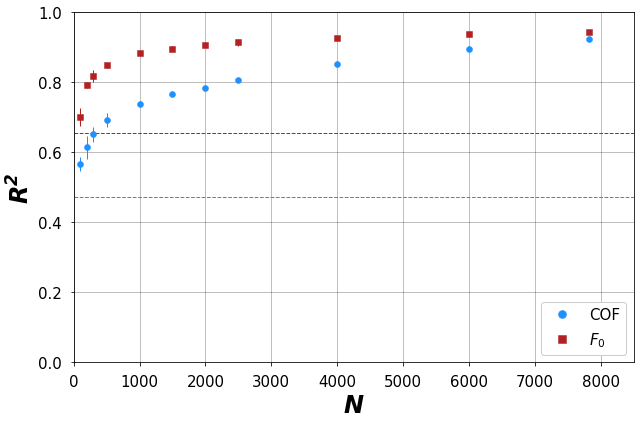

In [25]:
to_plot_on_5050 = {'COF': {'n_train': list(),
                           'r_square_avg': list(),
                           'r_square_std': list(),
                           'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['5050'][target].items():
        if 'everything' in model:
            to_plot_on_5050[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_5050[target]['r_square_std'].append(data['r_square_std'])
            to_plot_on_5050[target]['n_train'].append(data['n_train'])
        elif 'original' in model: 
            to_plot_on_5050[target]['base'] = data['r_square']
                
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0, 8500)
plt.ylim(0, 1)
plt.errorbar(x=to_plot_on_5050['COF']['n_train'],
            y=to_plot_on_5050['COF']['r_square_avg'],
            yerr=to_plot_on_5050['COF']['r_square_std'],
            color=COF_color,
            fmt='o',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_5050['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

plt.errorbar(x=to_plot_on_5050['intercept']['n_train'],
            y=to_plot_on_5050['intercept']['r_square_avg'],
            yerr=to_plot_on_5050['intercept']['r_square_std'],
            color=F0_color,
            fmt='s',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_5050['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)

legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/everything_on_5050.pdf', dpi=500)

# print('COF')
# print(f'n: {to_plot_on_5050["COF"]["n_train"]}')
# print(f'r2: {to_plot_on_5050["COF"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_5050["COF"]["r_square_std"]}')

# print('F0')
# print(f'n: {to_plot_on_5050["intercept"]["n_train"]}')
# print(f'r2: {to_plot_on_5050["intercept"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_5050["intercept"]["r_square_std"]}')
      

# Refined R<sup>2</sup> plot 
### Mixed 5050 models on 2575 test set

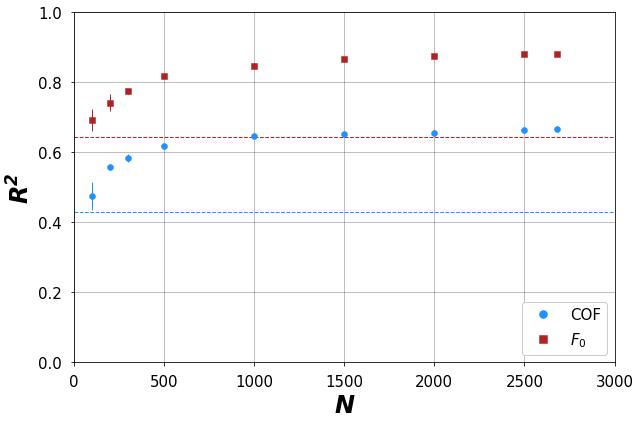

In [26]:
to_plot_on_2575 = {'COF': {'n_train': list(),
                           'r_square_avg': list(),
                           'r_square_std': list(),
                           'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['2575'][target].items():
        if '5050' in model:
            to_plot_on_2575[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_2575[target]['r_square_std'].append(data['r_square_std'])
            to_plot_on_2575[target]['n_train'].append(data['n_train'])
        elif 'original' in model: 
            to_plot_on_2575[target]['base'] = data['r_square']
                
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0, 3000)
plt.ylim(0, 1)
plt.errorbar(x=to_plot_on_2575['COF']['n_train'],
            y=to_plot_on_2575['COF']['r_square_avg'],
            yerr=to_plot_on_2575['COF']['r_square_std'],
            color=COF_color,
            fmt='o',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_2575['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

plt.errorbar(x=to_plot_on_2575['intercept']['n_train'],
            y=to_plot_on_2575['intercept']['r_square_avg'],
            yerr=to_plot_on_2575['intercept']['r_square_std'],
            color=F0_color,
            fmt='s',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_2575['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)


legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/5050_on_2575.pdf', dpi=500)

# print('COF')
# print(f'n: {to_plot_on_2575["COF"]["n_train"]}')
# print(f'r2: {to_plot_on_2575["COF"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_2575["COF"]["r_square_std"]}')

# print('F0')
# print(f'n: {to_plot_on_2575["intercept"]["n_train"]}')
# print(f'r2: {to_plot_on_2575["intercept"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_2575["intercept"]["r_square_std"]}')
      

# Refined R<sup>2</sup> plot 
### Everything models on 2575 test set

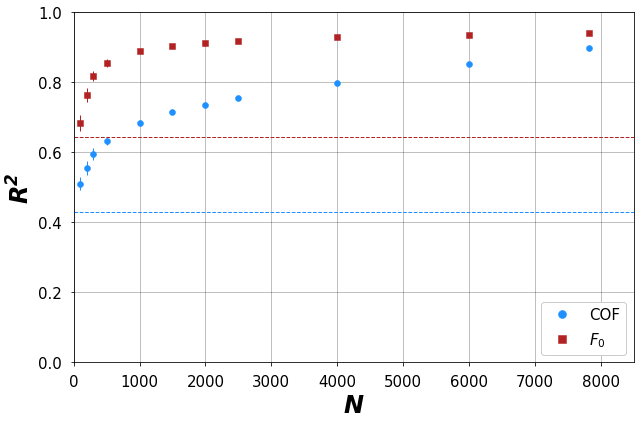

In [27]:
to_plot_on_2575 = {'COF': {'n_train': list(),
                           'r_square_avg': list(),
                           'r_square_std': list(),
                           'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['2575'][target].items():
        if 'everything' in model:
            to_plot_on_2575[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_2575[target]['r_square_std'].append(data['r_square_std'])
            to_plot_on_2575[target]['n_train'].append(data['n_train'])
        elif 'original' in model: 
            to_plot_on_2575[target]['base'] = data['r_square']
                
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0, 8500)
plt.ylim(0, 1)
plt.errorbar(x=to_plot_on_2575['COF']['n_train'],
            y=to_plot_on_2575['COF']['r_square_avg'],
            yerr=to_plot_on_2575['COF']['r_square_std'],
            color=COF_color,
            fmt='o',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_2575['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

plt.errorbar(x=to_plot_on_2575['intercept']['n_train'],
            y=to_plot_on_2575['intercept']['r_square_avg'],
            yerr=to_plot_on_2575['intercept']['r_square_std'],
            color=F0_color,
            fmt='s',
            markersize=markersize,
            elinewidth=1)
plt.axhline(y=to_plot_on_2575['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)

legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/everything_on_2575.pdf', dpi=500)

# print('COF')
# print(f'n: {to_plot_on_2575["COF"]["n_train"]}')
# print(f'r2: {to_plot_on_2575["COF"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_2575["COF"]["r_square_std"]}')

# print('F0')
# print(f'n: {to_plot_on_2575["intercept"]["n_train"]}')
# print(f'r2: {to_plot_on_2575["intercept"]["r_square_avg"]}')
# print(f'yerr: {to_plot_on_2575["intercept"]["r_square_std"]}')
      

# Refined R<sup>2</sup> plot 
### Everything model on everything test set

COF
n: [100, 200, 300, 500, 1000, 1500, 2000, 2500, 4000, 6000, 7816]
r2: [0.528154425724747, 0.5730288289557801, 0.6123714402073663, 0.6501984820122367, 0.7008796698252099, 0.7309954757288685, 0.7510696953441597, 0.7713000174040183, 0.8148007692937791, 0.8652240995884364, 0.9060796086918874]
yerr: [0.01793258317243838, 0.02100853386009354, 0.015270667829272283, 0.010027211648272078, 0.005074317725850501, 0.004394028784372859, 0.002806228454227297, 0.0034357840677379952, 0.0027947415881720413, 0.004201231724173016, 0.0002377727158844267]
F0
n: [100, 200, 300, 500, 1000, 1500, 2000, 2500, 4000, 6000, 7816]
r2: [0.689552012652797, 0.7720909208804384, 0.8174290035302588, 0.8529631278523242, 0.8876656375674521, 0.9018873867716799, 0.9101710220522508, 0.9172543385591807, 0.9282197231957239, 0.9361164507540922, 0.9415022939022075]
yerr: [0.018508448323936534, 0.014954392055256142, 0.013886603391925175, 0.0077953613951858985, 0.0047090779504702935, 0.0043428616736831925, 0.005579975406793458,

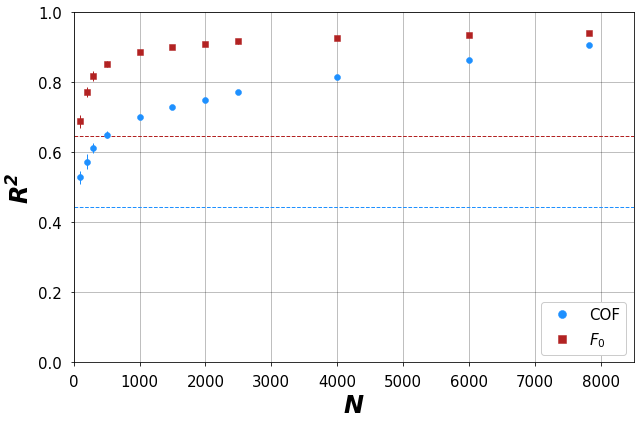

In [28]:
to_plot_on_everything = {'COF': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['everything'][target].items():
        if ('everything' in model):
            to_plot_on_everything[target]['n_train'].append(data['n_train'])
            to_plot_on_everything[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_everything[target]['r_square_std'].append(data['r_square_std'])
        elif 'original' in model: 
            to_plot_on_everything[target]['base'] = data['r_square']
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0,8500)
plt.ylim(0, 1)
plt.errorbar(x=to_plot_on_everything['COF']['n_train'],
            y=to_plot_on_everything['COF']['r_square_avg'],
            yerr=to_plot_on_everything['COF']['r_square_std'],
            fmt='o',
            markersize=markersize,
            color=COF_color,
            elinewidth=1)
plt.axhline(y=to_plot_on_everything['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

plt.errorbar(x=to_plot_on_everything['intercept']['n_train'],
            y=to_plot_on_everything['intercept']['r_square_avg'],
            yerr=to_plot_on_everything['intercept']['r_square_std'],
            fmt='s',
            markersize=markersize,
            color=F0_color,
            elinewidth=1)
plt.axhline(y=to_plot_on_everything['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)

legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/everything_on_everything.pdf', dpi=500)

print('COF')
print(f'n: {to_plot_on_everything["COF"]["n_train"]}')
print(f'r2: {to_plot_on_everything["COF"]["r_square_avg"]}')
print(f'yerr: {to_plot_on_everything["COF"]["r_square_std"]}')

print('F0')
print(f'n: {to_plot_on_everything["intercept"]["n_train"]}')
print(f'r2: {to_plot_on_everything["intercept"]["r_square_avg"]}')
print(f'yerr: {to_plot_on_everything["intercept"]["r_square_std"]}')
      

# Refined R<sup>2</sup> plot 
### 5050 model on everything test set

COF
n: [100, 200, 300, 500, 1000, 1500, 2000, 2500, 2680]
r2: [0.496151469978441, 0.5844114866790067, 0.6149743464541043, 0.6530931407596593, 0.6926178576498359, 0.706266117144744, 0.722812197550526, 0.7385909432988836, 0.7446405527214718]
yerr: [0.04604489577667854, 0.008409894381901076, 0.012504525038827355, 0.00407509559557999, 0.001964926945100505, 0.005061256569109001, 0.0057804133592025235, 0.002400331981821221, 0.00026586491857588895]
F0
n: [100, 200, 300, 500, 1000, 1500, 2000, 2500, 2680]
r2: [0.7011696908563746, 0.7574869054660034, 0.7899601582469192, 0.8313355275548936, 0.8589732397811363, 0.8789495443944263, 0.8884625189700902, 0.8946440640683505, 0.8959240765619937]
yerr: [0.032363686230369546, 0.02617355547560678, 0.007479677721319424, 0.003521506602785101, 0.005423900021555742, 0.0030406900380948215, 0.0032505967649548648, 0.0009177731606177767, 0.00016436858961490784]


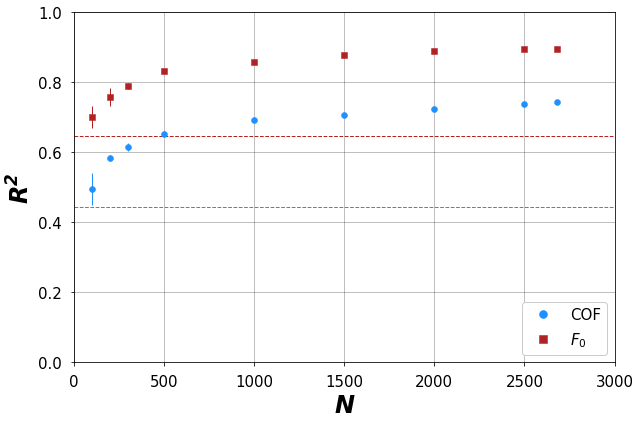

In [29]:
to_plot_on_everything = {'COF': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None},
                   'intercept': {'n_train': list(),
                                 'r_square_avg': list(),
                                 'r_square_std': list(),
                                 'base': None}}
for target in ['COF', 'intercept']:
    for model, data in results['everything'][target].items():
        if ('5050' in model):
            to_plot_on_everything[target]['n_train'].append(data['n_train'])
            to_plot_on_everything[target]['r_square_avg'].append(data['r_square_avg'])
            to_plot_on_everything[target]['r_square_std'].append(data['r_square_std'])
        elif 'original' in model: 
            to_plot_on_everything[target]['base'] = data['r_square']
plt.figure(figsize=(9, 6))

#plt.title('Effect of Training Set Size', fontsize=20)
plt.xlabel('N', style='italic')
plt.ylabel(r'$\mathbf{R^2}$')
plt.xlim(0, 3000)
plt.ylim(0, 1)
plt.errorbar(x=to_plot_on_everything['COF']['n_train'],
            y=to_plot_on_everything['COF']['r_square_avg'],
            yerr=to_plot_on_everything['COF']['r_square_std'],
            fmt='o',
            markersize=markersize,
            color=COF_color,
            elinewidth=1)
plt.axhline(y=to_plot_on_everything['COF']['base'], linestyle='--', linewidth=1, color=COF_color)

plt.errorbar(x=to_plot_on_everything['intercept']['n_train'],
            y=to_plot_on_everything['intercept']['r_square_avg'],
            yerr=to_plot_on_everything['intercept']['r_square_std'],
            fmt='s',
            markersize=markersize,
            color=F0_color,
            elinewidth=1)
plt.axhline(y=to_plot_on_everything['intercept']['base'], linestyle='--', linewidth=1, color=F0_color)

legend_elements = [Line2D([0], [0], marker='o', color=COF_color, linestyle='', label='COF'),
                   Line2D([0], [0], marker='s', color=F0_color, linestyle='', label=r'$\mathit{F_0}$')]
plt.legend(handles=legend_elements, loc=4)
plt.savefig(fname='./plots/r2vsN/5050_on_everything.pdf', dpi=500)
print('COF')
print(f'n: {to_plot_on_everything["COF"]["n_train"]}')
print(f'r2: {to_plot_on_everything["COF"]["r_square_avg"]}')
print(f'yerr: {to_plot_on_everything["COF"]["r_square_std"]}')

print('F0')
print(f'n: {to_plot_on_everything["intercept"]["n_train"]}')
print(f'r2: {to_plot_on_everything["intercept"]["r_square_avg"]}')
print(f'yerr: {to_plot_on_everything["intercept"]["r_square_std"]}')
      

# Summary Table

In [17]:
import pandas as pd

In [19]:
pd_dict = {'model_name' : list(),
           'n_trains' : list(),
           '5050_COF' : list(),
           '5050_F0' : list(),
           '2575_COF' : list(),
           '2575_F0' : list(),
           'everything_COF' : list(),
           'everything_F0' : list()}

# Handle original models 
pd_dict['model_name'].append('original')
pd_dict['n_trains'].append(100)
for tset in ['5050', '2575', 'everything']:
    pd_dict[f'{tset}_COF'].append(round(results[tset]['COF']['original']['r_square'], 3))
    pd_dict[f'{tset}_F0'].append(round(results[tset]['intercept']['original']['r_square'], 3))


# Handle 5050 models
for point in mpoints:
    model_name = f'5050_{point}'
    pd_dict['model_name'].append(model_name)
    pd_dict['n_trains'].append(point)
    for tset in ['5050', '2575', 'everything']:
        COF = f"{round(results[tset]['COF'][model_name]['r_square_avg'], 3)} \u00B1 {round(results[tset]['COF'][model_name]['r_square_std'], 3)}"
        F0 = f"{round(results[tset]['intercept'][model_name]['r_square_avg'], 3)} \u00B1 {round(results[tset]['intercept'][model_name]['r_square_std'], 3)}"

        pd_dict[f'{tset}_COF'].append(COF)
        pd_dict[f'{tset}_F0'].append(F0)
        
        
# Handle 2575 models

for point in epoints:
    model_name = f'everything_{point}'
    pd_dict['model_name'].append(model_name)
    pd_dict['n_trains'].append(point)
    for tset in ['5050', '2575', 'everything']:
        COF = f"{round(results[tset]['COF'][model_name]['r_square_avg'], 3)} \u00B1 {round(results[tset]['COF'][model_name]['r_square_std'], 3)}"
        F0 = f"{round(results[tset]['intercept'][model_name]['r_square_avg'], 3)} \u00B1 {round(results[tset]['intercept'][model_name]['r_square_std'], 3)}"

        pd_dict[f'{tset}_COF'].append(COF)
        pd_dict[f'{tset}_F0'].append(F0)

In [20]:
df = pd.DataFrame(pd_dict)

In [21]:
df.to_csv('plots/summary_r2.csv')

In [22]:
plt.close()